In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from '/usr/local/lib/python3.6/site-packages/pandas/__init__.py'>

In [22]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

for symbol in NASDAQ100:
# for symbol in ['NDX']:
    if symbol == 'AMZN':
        ignore = False
    if ignore:
        continue
    datafile = spider.get_stock_data(symbol, timeframe)
    print(datafile)
    pass

KeyboardInterrupt: 

In [3]:
%%time

### 业务设置

start_date = '2008-06-02'
# start_date = '2017-01-03'
end_date = '2018-05-01'


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.8 µs


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
    stock_df['pct_change'] = stock_df.close.pct_change(1)
    stock_df['open_pct_change'] = stock_df.open.pct_change(1)
    
    # 减少数据
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

CPU times: user 1min 35s, sys: 174 ms, total: 1min 35s
Wall time: 1min 37s


In [5]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.17 ms


In [6]:
%%time
# %%lprun

### Turtle
TURTLE_POS = 10
TURTLE_BUY_N = 20
TURTLE_SELL_N = 20

is_happy_money = False
HAPPY_MONEY = 0
PROPERTY = 100000
CASH = 100000
hold = []
order_df = pd.DataFrame(columns=['buy_date', 'symbol', 'buy_count', 'buy_price', 'sell_date', 'sell_price', 'profit', 'cash', 'property'])
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df.index:
        order = order_df.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        is_sell = (stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today])
#         is_sell = False
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count']
#             print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order['symbol'], order['buy_count'], stock_df_dict[order[1]].loc[today, 'open'], CASH, PROPERTY))
            order_df.loc[idx, 'sell_date'] = today
            order_df.loc[idx, 'sell_price'] = stock_df_dict[order[1]].loc[today, 'open']
            order_df.loc[idx, 'profit'] = (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
            if CASH < 100000 / TURTLE_POS:
                continue
            buy = int(100000 / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
#             print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': 0,
                    'property': 0,
                },
                ignore_index=True
            )
            
    
    show_df.loc[today, 'CASH_TURTLE'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


9638.761700000034
0
170301.96170000004
[]
NDX 2028.33 6592.927 3.2504212825329213
CPU times: user 8min, sys: 266 ms, total: 8min
Wall time: 8min 3s


In [18]:
symbol = 'BIDU'
rolling_max_dict[symbol]
stock_df_dict[symbol]
sum(list(order_df['profit']))
# [order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index]
# sum([stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] for idx in order_df.loc[order_df['sell_price']==0].index])
order_df
# order_df.loc[order_df['sell_price']==0]

date
2013-05-20       NaN
2013-05-21       NaN
2013-05-22       NaN
2013-05-23       NaN
2013-05-24       NaN
2013-05-28       NaN
2013-05-29       NaN
2013-05-30       NaN
2013-05-31       NaN
2013-06-03       NaN
2013-06-04       NaN
2013-06-05       NaN
2013-06-06       NaN
2013-06-07       NaN
2013-06-10       NaN
2013-06-11       NaN
2013-06-12       NaN
2013-06-13       NaN
2013-06-14       NaN
2013-06-17    102.48
2013-06-18    102.48
2013-06-19    102.48
2013-06-20    102.48
2013-06-21    102.48
2013-06-24    102.48
2013-06-25    102.48
2013-06-26    102.48
2013-06-27    102.48
2013-06-28    102.48
2013-07-01    102.48
               ...  
2018-04-06    268.00
2018-04-09    268.00
2018-04-10    268.00
2018-04-11    263.01
2018-04-12    263.01
2018-04-13    261.47
2018-04-16    261.47
2018-04-17    254.26
2018-04-18    254.26
2018-04-19    245.00
2018-04-20    239.38
2018-04-23    239.38
2018-04-24    239.38
2018-04-25    238.43
2018-04-26    238.43
2018-04-27    253.95
2018-04-

,open,close,pct_change,open_pct_change
date,,,,
2013-05-20,94.72,100.490,NaN,NaN
2013-05-21,100.30,99.030,-0.014529,0.058910
2013-05-22,98.80,95.140,-0.039281,-0.014955
2013-05-23,92.81,93.890,-0.013139,-0.060628
2013-05-24,93.75,96.450,0.027266,0.010128
2013-05-28,97.88,97.280,0.008605,0.044053
2013-05-29,96.94,96.550,-0.007504,-0.009604
2013-05-30,96.18,97.770,0.012636,-0.007840
2013-05-31,97.50,96.640,-0.011558,0.013724


69121.09169999999

,buy_date,symbol,buy_count,buy_price,sell_date,sell_price,profit,cash,property
0,2013-06-17,AVGO,264,37.8000,2013-07-25,36.5,-343.2,0,0
1,2013-06-17,CHTR,76,129.9602,2013-08-15,136.662,509.352,0,0
2,2013-06-17,CTRP,581,17.1900,2013-11-07,26.8,5583.41,0,0
3,2013-06-17,HSIC,204,48.8400,2013-06-21,47.01,-373.32,0,0
4,2013-06-17,IDXX,222,45.0450,2013-08-16,47.71,591.63,0,0
5,2013-06-17,MU,759,13.1600,2013-07-12,12.74,-318.78,0,0
6,2013-06-17,MYL,314,31.8300,2013-08-29,34.83,942,0,0
7,2013-06-17,SBUX,302,33.0950,2013-08-28,35.045,588.9,0,0
8,2013-06-17,TMUS,451,22.1600,2013-08-19,23.65,671.99,0,0
9,2013-06-18,AMZN,35,279.0800,2013-08-08,298.52,680.4,0,0


In [8]:
%%time

### Turtle + BT
TURTLE_POS = 10
TURTLE_BUY_N = 20
TURTLE_SELL_N = 20

is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY
hold = []
order_df_TB = pd.DataFrame(
    columns=['buy_date', 'strategy', 'symbol', 'buy_count', 'buy_price', 'expect', 'sell_date', 'sell_price', 'profit', 'cash', 'property']
)
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df_TB.index:
        order = order_df_TB.iloc[idx]
        
        if order['sell_price'] != 0:
            continue
        
        if order['strategy'] == 'TURTLE':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'open'] == rolling_min_dict[order['symbol']].loc[today]
        elif order['strategy'] == 'BT':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'open'] > order['expect']
            is_sell = is_sell or stock_df_dict[order['symbol']].loc[today, 'open'] / order['buy_price'] < 0.8
            is_sell = is_sell or today - order['buy_date'] > 30
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'open'] * order['buy_count']
#             print('%s 售出 %s SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order['strategy'], order['symbol'], order['buy_count'], stock_df_dict[order['symbol']].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB.loc[idx, 'sell_date'] = today
            order_df_TB.loc[idx, 'sell_price'] = stock_df_dict[order['symbol']].loc[today, 'open']
            order_df_TB.loc[idx, 'profit'] = (order_df_TB.loc[idx, 'sell_price'] - order_df_TB.loc[idx, 'buy_price']) * order_df_TB.loc[idx, 'buy_count']
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            continue
        
        is_buy = False
        
        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] == rolling_max_dict[symbol].loc[today])
            if is_buy:
                strategy = 'TURTLE'

        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'open_pct_change'] < -0.05)
            if is_buy:
                strategy = 'BT'
        
        if is_buy:
            if CASH < START_MONEY / TURTLE_POS:
                continue
            buy = int(START_MONEY / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
#             print('%s 进场 %s BUY %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, strategy, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB = order_df_TB.append(
                {
                    'buy_date': today,
                    'strategy': strategy,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'open'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': 0,
                    'property': 0,
                },
                ignore_index=True
            )
            
    show_df.loc[today, 'CASH_T+B'] = CASH
    PROPERTY = CASH + \
        sum([stock_df_dict[order_df_TB.loc[idx, 'symbol']].loc[today, 'open'] * order_df_TB.loc[idx, 'buy_count'] for idx in order_df_TB.loc[order_df_TB['sell_price']==0].index])
    show_df.loc[today, 'PROPERTY_T+B'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'open']
e_p = stock_df_dict['NDX'].loc[end_date, 'open']
print('NDX', s_p, e_p, e_p / s_p)


3723.3997999999956
0
292434.82980000007
[]
NDX 2028.33 6592.927 3.2504212825329213
CPU times: user 12min 2s, sys: 283 ms, total: 12min 3s
Wall time: 12min 5s


In [9]:
len(order_df_TB)
turtle_df = order_df_TB.loc[order_df_TB['strategy']=='TURTLE']
bt_df = order_df_TB.loc[order_df_TB['strategy']=='TURTLE']
len(turtle_df)
order_df_TB
# order_df_TB.loc[order_df_TB['strategy']=='BT']

692

491

,buy_date,strategy,symbol,buy_count,buy_price,expect,sell_date,sell_price,profit,cash,property
0,2013-05-23,BT,BIDU,107,92.8100,98.8000,2013-06-07,99.57,723.32,0,0
1,2013-05-23,BT,MELI,84,118.3700,124.7900,2013-06-24,106.43,-1002.96,0,0
2,2013-05-23,BT,NVDA,702,14.2300,14.9800,2013-06-24,14.21,-14.04,0,0
3,2013-05-23,BT,TMUS,519,19.2600,20.7700,2013-05-30,21.04,923.82,0,0
4,2013-05-29,BT,NFLX,326,30.6500,33.1071,2013-07-01,30.5171,-43.3254,0,0
5,2013-05-30,BT,TSLA,97,102.4600,113.5500,2013-07-01,109.36,669.3,0,0
6,2013-06-03,BT,TSLA,102,97.6200,106.2600,2013-06-27,106.75,931.26,0,0
7,2013-06-06,BT,FAST,209,47.7000,50.3200,2013-07-08,46.11,-332.31,0,0
8,2013-06-11,BT,LBTYK,331,30.1911,31.9144,2013-07-05,32.2394,677.987,0,0
9,2013-06-12,BT,WDAY,162,61.6900,65.1700,2013-07-05,65.31,586.44,0,0


In [10]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)


In [11]:
# pd.set_option('display.max_rows', 1000)
# record_df
# record_df.loc[record_df['ops']=='SELL'].sort_values(by=['profit'])

In [12]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = order_df_TB.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-40, 40)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600))

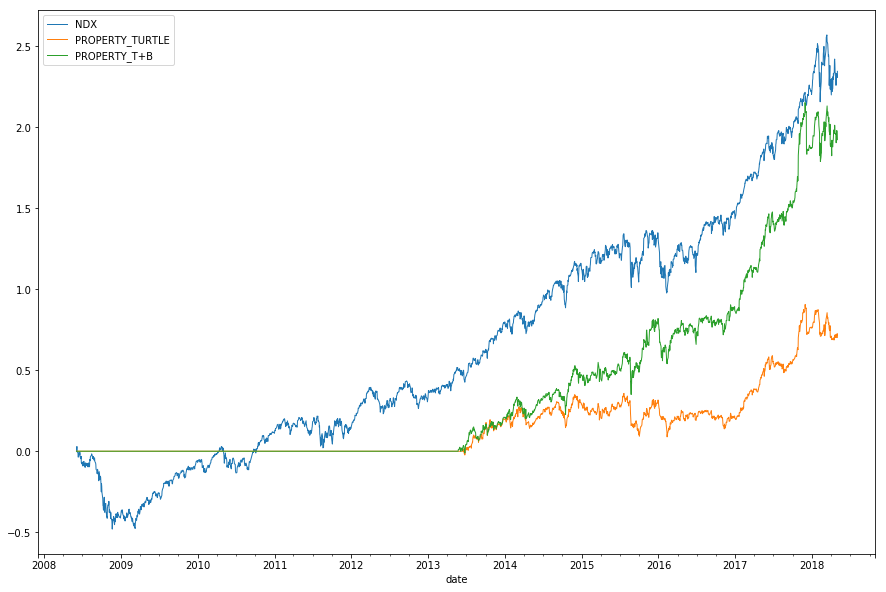

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_TURTLE'] = (df['PROPERTY_TURTLE'] - df.iloc[0]['PROPERTY_TURTLE']) / df.iloc[0]['PROPERTY_TURTLE']
df['PROPERTY_T+B'] = (df['PROPERTY_T+B'] - df.iloc[0]['PROPERTY_T+B']) / df.iloc[0]['PROPERTY_T+B']

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY_TURTLE', secondary_y=False, label='PROPERTY_TURTLE', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T+B', secondary_y=False, label='PROPERTY_T+B', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()